   
    
1. Importing Modules
    
2. Loading Data
    
3. Data PreProcessing 
       
4. Modelling With LSTM And Tuning The Hyperparameters 
    
5. Results And Conclusion

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


In [ ]:
#Loading The Data
df_train = pd.read_csv("../input/gooogle-stock-price/Google_Stock_Price_Train.csv")


In [4]:
df_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [ ]:
# Data Preprocessing
df_closing = df_train['Close'].apply(lambda x : x.replace(',', '')).astype('float')
df_closing.head()

0    663.59
1    666.45
2    657.21
3    648.24
4    620.76
Name: Close, dtype: float64

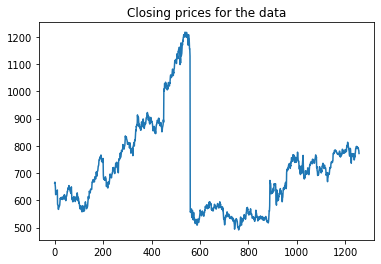

In [6]:

plt.plot(df_closing.values);
plt.title("Closing prices for the data");


In [7]:
# Scaling The Data
scaler=MinMaxScaler(feature_range=(0,1))
df_closing=scaler.fit_transform(np.array(df_closing).reshape(-1,1))

In [8]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []
    
    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset[i:(i+time_step), 0])
        y_data.append(dataset[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [9]:
# Preparing train and test data

training_size=int(len(df_closing)*0.65)
test_size=len(df_closing)-training_size
train_data,test_data=df_closing[0:training_size,:],df_closing[training_size:len(df_closing),:1]

In [10]:
#Taking data for past 100 days for next prediction
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
#Model Building
def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]),return_sequences=True,input_shape=(100,1)))
    
    for i in range(hp.Int('num_layers', 2, 15)):                        
        model.add(layers.LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam' )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,
    executions_per_trial=3,
    directory='project', project_name = 'Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs= 5,
             validation_data=(X_test, ytest))

Trial 5 Complete [00h 08m 53s]
val_loss: 0.003724696347489953

Best val_loss So Far: 0.0031300268601626158
Total elapsed time: 00h 41m 36s


In [13]:
tuner.results_summary()


Results summary
Results in project/Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layer1_units: 90
num_layers: 13
units0: 130
units1: 90
last_lstm_units: 50
rate: 0.7
units2: 80
units3: 140
units4: 30
units5: 70
units6: 80
units7: 140
units8: 100
units9: 90
units10: 80
units11: 110
units12: 10
Score: 0.0031300268601626158
Trial summary
Hyperparameters:
layer1_units: 90
num_layers: 7
units0: 120
units1: 40
last_lstm_units: 50
rate: 0.4
units2: 140
units3: 20
units4: 20
units5: 130
units6: 80
units7: 120
units8: 70
units9: 110
units10: 20
units11: 70
units12: 60
Score: 0.003224501386284828
Trial summary
Hyperparameters:
layer1_units: 20
num_layers: 11
units0: 70
units1: 90
last_lstm_units: 50
rate: 0.4
units2: 50
units3: 40
units4: 100
units5: 120
units6: 50
units7: 50
units8: 130
units9: 110
units10: 20
units11: 20
units12: 110
Score: 0.003724696347489953
Trial summary
Hyperparameters:
layer1_units: 50
num_

In [14]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 90)           33120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 130)          114920    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 90)           79560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 80)           54720     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 140)          123760    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 30)           20520     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 70)           2

In [15]:
model_history = model.fit(X_train,y_train, epochs=100, validation_data=(X_test,ytest))

Epoch 1/100
23/23 [==============================] - 71s 2s/step - loss: 0.0301 - val_loss: 0.0083
Epoch 2/100
23/23 [==============================] - 36s 2s/step - loss: 0.0333 - val_loss: 0.0037
Epoch 3/100
23/23 [==============================] - 37s 2s/step - loss: 0.0309 - val_loss: 0.0119
Epoch 4/100
23/23 [==============================] - 37s 2s/step - loss: 0.0295 - val_loss: 0.0029
Epoch 5/100
23/23 [==============================] - 36s 2s/step - loss: 0.0242 - val_loss: 0.0055
Epoch 6/100
23/23 [==============================] - 36s 2s/step - loss: 0.0238 - val_loss: 0.0032
Epoch 7/100
23/23 [==============================] - 36s 2s/step - loss: 0.0198 - val_loss: 0.0051
Epoch 8/100
23/23 [==============================] - 37s 2s/step - loss: 0.0245 - val_loss: 0.0017
Epoch 9/100
23/23 [==============================] - 36s 2s/step - loss: 0.0257 - val_loss: 0.0071
Epoch 10/100
23/23 [==============================] - 37s 2s/step - loss: 0.0234 - val_loss: 0.0020
Epoch 11/

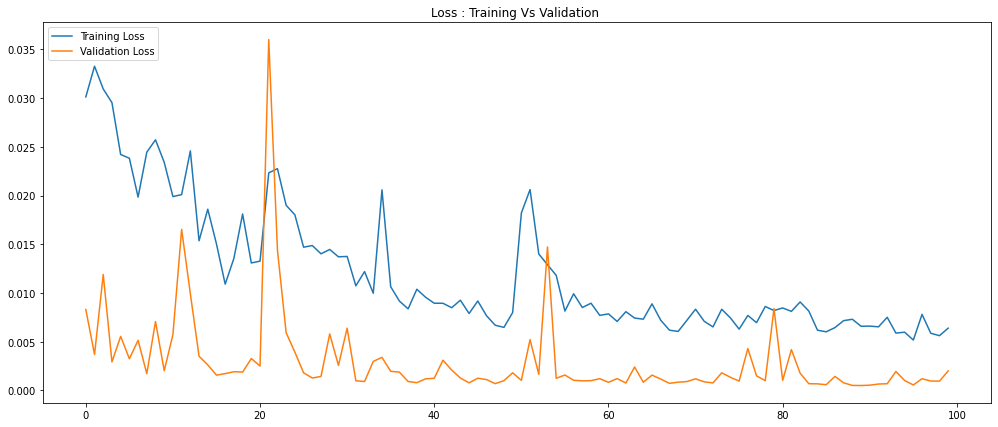

In [16]:
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']



plt.figure(figsize=(17, 7));
plt.plot(range(100), loss, label='Training Loss');
plt.plot(range(100), validation_loss, label='Validation Loss');
plt.legend(loc='upper left');
plt.title('Loss : Training Vs Validation ');

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

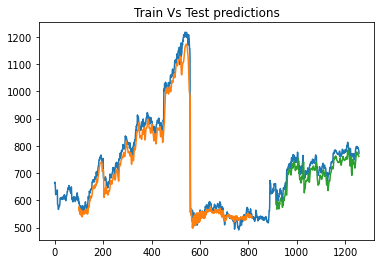

In [19]:
look_back=100
trainPredictPlot = np.empty_like(df_closing)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_closing)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_closing)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df_closing))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Train Vs Test predictions');
plt.show()


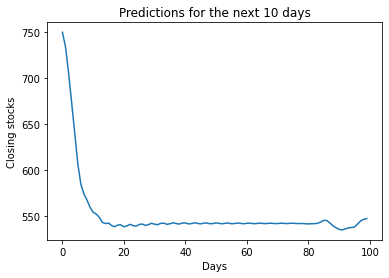

In [ ]:
#Predictig for next 10 Days
future_predictions = test_data.copy()
for i in range(100):
    new_prediction = model.predict(((future_predictions[341+i:])).reshape(1,100,1))
    future_predictions = np.append(future_predictions, new_prediction)
    
plt.plot(scaler.inverse_transform(future_predictions[441:].reshape(-1, 1)));
plt.title('Predictions for the next 10 days');
plt.xlabel('Days');
plt.ylabel('Closing stocks');


In [21]:
print("Train RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test RMSE: ", math.sqrt(mean_squared_error(ytest,test_predict)))


Train RMSE:  739.7700492279813
Test RMSE:  701.8448657841902


# The model is performing pretty well, train and test MSE are close.